# Transformer-Based TTS Model "Falafeltron"

This project was developed in Kaggle, utilizing their GPU resources for training. The notebook contains Kaggle-specific paths that may need adjustment if running in a different environment.

# Imports

In [20]:
# Standard Library Imports
import os  # Operating system interfaces
import logging  # Logging module to track events and debug
from datetime import datetime  # Working with date and time

# Numerical and Data Handling Libraries
import numpy as np  # Numerical computing
import pandas as pd  # Data manipulation and analysis

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting graphs
from IPython.display import Image, display

# Deep Learning - PyTorch
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional layers (e.g., activation functions)
import torch.optim as optim  # Optimization algorithms
import torch.utils.data as data  # Dataset handling
from torch.utils.data import DataLoader, random_split  # Data loading and splitting utilities
from torch.nn.utils import weight_norm  # Weight normalization utility
from torch.utils.data import Dataset
from torch.nn.utils import remove_weight_norm

# Audio Processing Libraries
import librosa  # Audio processing and analysis
import librosa.filters  # Filters for spectral analysis
import scipy  # Scientific computing
from scipy.io import wavfile  # Read and write WAV files
import soundfile as sf  # Read and write sound files

# Utility Libraries
from tqdm import tqdm  # Progress bar for loops
import copy  # Deep copying objects
import math  # Mathematical operations
import sys  # System-specific parameters and functions

# Learning Rate Scheduling
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduling

# Transformer Models in PyTorch
from torch.nn import TransformerEncoderLayer, TransformerDecoderLayer  # Transformer layers

# Experiment Tracking and Logging
import wandb  # Weights and Biases for experiment tracking

# Audio Playback (for Jupyter Notebooks)
import IPython.display as ipd  # Interactive display utilities for audio

## 🔹 Audio Processor Class
- **Role**: Converts raw audio into mel spectrograms following WaveGlow training parameters.
- **Implementation Details**:
   - Uses STFT (librosa.stft) with a **Hann window - same as Tacotron window**.
   - Creates 80-bin mel spectrograms (standard for speech synthesis).
   - Implements log compression and optional mean-std normalization.
- **Why It’s Important**:
  -  Ensures mel spectrograms match the expected input format for Tacotron & WaveGlow.
  -  Uses parameters compatible with NVIDIA’s TTS pipeline (i.e., hop_length=256, n_fft=1024)

In [21]:
class AudioProcessor:
    """
    AudioProcessor for creating mel spectrograms that match
    NVIDIA WaveGlow training parameters by default.
    """
    def __init__(
        self,
        sample_rate=22050,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        n_mels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,
        clip_val=1e-5,
        center=False,  # Official code typically uses center=False
        do_normalization=False,
        norm_min=-3.0,
        norm_max=3.0
    ):
        """
        Args:
            sample_rate (int): Audio sample rate, typically 22050 for WaveGlow.
            n_fft (int): FFT size, 1024 in official WaveGlow.
            hop_length (int): STFT hop length, 256 in official WaveGlow.
            win_length (int): STFT window length, 1024 in official WaveGlow.
            n_mels (int): Number of mel bins, 80 in official WaveGlow.
            mel_fmin (float): Minimum frequency for mel filter.
            mel_fmax (float): Maximum frequency for mel filter (8000 for WaveGlow).
            clip_val (float): Clip magnitude for log compression (avoid log(0)).
            center (bool): If False, no librosa center padding (official style).
            do_normalization (bool): If True, do per-sample mean/std normalization 
                                     after log-mel. (Usually best turned off 
                                     for official WaveGlow.)
            norm_min (float): If normalizing, clip lower bound.
            norm_max (float): If normalizing, clip upper bound.
        """
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.n_mels = n_mels
        self.mel_fmin = mel_fmin
        self.mel_fmax = mel_fmax
        self.clip_val = clip_val
        self.center = center
        self.do_normalization = do_normalization
        self.norm_min = norm_min
        self.norm_max = norm_max

        # Create mel filter using librosa
        self.mel_filter = librosa.filters.mel(
            sr=self.sample_rate,
            n_fft=self.n_fft,
            n_mels=self.n_mels,
            fmin=self.mel_fmin,
            fmax=self.mel_fmax,
            htk=True  # Matches NVIDIA style
        )

    def create_mel_spectrogram(self, audio):
        """
        Convert a 1D audio signal (float32) in [-1, 1] to an [n_mels, T] log-mel spectrogram.
        """
        # If it's a torch.Tensor, convert to numpy
        if isinstance(audio, torch.Tensor):
            audio = audio.detach().cpu().numpy()

        # Ensure float32
        audio = audio.astype(np.float32)

        # Normalize audio to [-1, 1] if needed
        if np.max(np.abs(audio)) > 0:
            audio /= np.max(np.abs(audio))

        # STFT
        D = librosa.stft(
            audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window='hann',
            center=self.center,
            pad_mode='reflect'
        )
        mag = np.abs(D)

        # Apply mel filter
        mel_spec = np.dot(self.mel_filter, mag)

        # Log dynamic range compression
        mel_spec = np.log(np.clip(mel_spec, self.clip_val, None))

        # Optionally do per-sample mean/std normalization
        if self.do_normalization:
            mel_mean = mel_spec.mean()
            mel_std = mel_spec.std() + 1e-5
            mel_spec = (mel_spec - mel_mean) / mel_std
            mel_spec = np.clip(mel_spec, self.norm_min, self.norm_max)

        return mel_spec

## 🔹Load WaveGlow from NVIDIA PyTorch Hub
- **Role**: Converts mel spectrograms into waveforms using NVIDIA’s pretrained WaveGlow vocoder.
- **Implementation Details**:
  - Uses NVIDIA’s TorchHub model (nvidia_waveglow).
  - Removes weight normalization (to stabilize inference).
- **Why It’s Important**:
  - High-quality waveform synthesis without requiring **Griffin-Lim**.
  - Works with 22050Hz mel spectrograms, aligning with our Tacotron model


In [22]:
class WaveGlowVocoder(nn.Module):
    """
    Wraps NVIDIA's pretrained WaveGlow model for inference.
    Includes fix for remove_weightnorm() 
    and optional denoiser if installed.
    """
    def __init__(self, device=None, denoiser_strength=0.0):
        """
        Args:
            device (torch.device): 'cuda' or 'cpu'. If None, auto-detect.
            denoiser_strength (float): If >0, applies NVIDIA's WaveGlow denoiser
                                       after inference to reduce hiss.
        """
        super().__init__()
        
        # Auto device
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        # Load WaveGlow from Torch Hub
        print("[WaveGlowVocoder] Loading official WaveGlow from torch.hub ...")
        waveglow_model = torch.hub.load(
            "NVIDIA/DeepLearningExamples:torchhub",
            "nvidia_waveglow",
            model_math="fp32",
            trust_repo=True
        )
        # Properly remove weightnorm
        waveglow_model = waveglow_model.remove_weightnorm(waveglow_model)

        waveglow_model.eval()
        waveglow_model.to(device)

        self.waveglow = waveglow_model
        self.denoiser_strength = denoiser_strength

        # Try denoiser
        try:
            from nvidia_waveglow_denoiser import Denoiser
            self.denoiser = Denoiser(self.waveglow).to(device)
            print("[WaveGlowVocoder] Denoiser loaded. Strength set to", denoiser_strength)
        except ImportError:
            self.denoiser = None
            print("[WaveGlowVocoder] Denoiser not found, skipping.")
    
    def forward(self, mel_spec: torch.Tensor, sigma=0.6):
        """
        Args:
          mel_spec (torch.Tensor): shape (B, 80, T) 
                                   (the mel from your TTS model or AudioProcessor)
          sigma (float): sampling variance for WaveGlow (0.3-1.0 typical)
        
        Returns:
          audio (torch.Tensor): shape (B, 1, N_samples) on self.device
        """
        mel_spec = mel_spec.to(self.device)
        
        with torch.no_grad():
            # WaveGlow inference
            audio = self.waveglow.infer(mel_spec, sigma=sigma)
        
        # Optional denoising
        if self.denoiser and self.denoiser_strength > 0.0:
            with torch.no_grad():
                audio = self.denoiser(audio, self.denoiser_strength)
        
        return audio

## 🔹 LJSpeech Dataset Class
- **Role**: Loads the LJSpeech dataset, extracts text & audio features, and prepares batches.
- **Implementation Details:**
  - Reads text transcription (metadata.csv).
  - Converts text into character-level indices (char_to_id).
  - Generates mel spectrograms using AudioProcessor.
  - Implements custom collation for efficient batching.
- **Why It’s Important:**
  - Prepares data efficiently for training.
  - Handles variable-length text & audio inputs.
  - Uses padding & sorting to optimize training efficiency.



In [23]:

##############################################
# Dataset, Collate Function, and Visualization
##############################################
class LJSpeechDataset(Dataset):
    def __init__(self, metadata_path, audio_dir):
        super().__init__()
        self.metadata = pd.read_csv(
            metadata_path,
            sep='|',
            header=None,
            names=['ID', 'Transcription', 'Normalized_Transcription', 'Duration']
        )
        self.metadata['Normalized_Transcription'] = self.metadata['Normalized_Transcription'].fillna('').astype(str)
        self.metadata['Duration'] = self.metadata['Duration'].astype(float)
        self.audio_dir = audio_dir
        self.audio_processor = AudioProcessor()

        # Build character vocabulary (reserve index 0 for <pad>)
        base_chars = set(''.join(self.metadata['Normalized_Transcription']))
        special_chars = set('.,!?-\'\"() ')
        all_chars = sorted(list(base_chars | special_chars))
        all_chars = ['<pad>'] + all_chars
        self.char_to_id = {char: i for i, char in enumerate(all_chars)}
        self.id_to_char = {i: char for char, i in self.char_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        audio_path = os.path.join(self.audio_dir, f"{row['ID']}.wav")
        audio, sr = librosa.load(audio_path, sr=22050)

        # Only create mel
        mel_spec = self.audio_processor.create_mel_spectrogram(audio)

        # Convert text to IDs
        text = [self.char_to_id[c] for c in row['Normalized_Transcription']]

        return {
            'text': torch.LongTensor(text),
            'mel': torch.FloatTensor(mel_spec), 
            'audio': torch.FloatTensor(audio)
        }


def collate_fn(batch):
    # Sort by text length (descending)
    batch = sorted(batch, key=lambda x: len(x['text']), reverse=True)

    max_text_len = max(len(x['text']) for x in batch)
    max_mel_len = max(x['mel'].size(1) for x in batch)  # dimension [80, T]

    # Create padded tensors
    text_padded = torch.LongTensor(len(batch), max_text_len).zero_()
    mel_padded = torch.FloatTensor(len(batch), 80, max_mel_len).zero_()

    text_lengths = []
    mel_lengths = []

    for i, item in enumerate(batch):
        text = item['text']
        mel = item['mel']
        text_padded[i, :len(text)] = text
        mel_padded[i, :, :mel.size(1)] = mel
        text_lengths.append(len(text))
        mel_lengths.append(mel.size(1))

    return text_padded, mel_padded, torch.LongTensor(text_lengths), torch.LongTensor(mel_lengths)


# 🥙 FalafelTron - Improved Transformer-Based TTS Model
### Our Architecture:

## ➖ Positional Encoding


In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

- **Purpose**

Since Transformers do not have recurrence, they lack the ability to process sequences in order. 
  **Positional Encoding** injects sequential information into embeddings so that Transformers can model time-dependent relationships.

- **How It Works**

  - Uses sinusoidal functions to encode position values.
  - Adds positional encoding directly to input embeddings.
  - Ensures different positions have unique encoding but similar patterns.

    
- **Why It’s Better than Tacotron?**
  - Removes reliance on recurrence (which was a bottleneck in Tacotron).
  - Speeds up training and improves long-term sequence modeling.
---

## ➖ PreNet

In [25]:
class PreNet(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, out_dim=256, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

- Applies fully connected layers before feeding input to the Transformer.
- Acts as a bottleneck to encourage robust feature extraction.
- Prepares input features for the Transformer encoder.
- Helps prevent overfitting using dropout regularization.
---

## ➖ Encoder - Transformer based

In [164]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_chars, d_model=256, nhead=4, num_layers=4,
                 dim_feedforward=1024, dropout=0.1, padding_idx=0):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(num_chars, d_model, padding_idx=padding_idx)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu",
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        src_key_padding_mask = (x == 0)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        memory = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        return memory

- **Purpose**
  - Encodes input character sequences into a contextual representation.
  - Uses self-attention to learn relationships without recurrence.
- **Key Features**
  - Embeds character inputs → 256D representation.
  - Adds positional encoding.
  - Uses a Transformer stack (multi-head attention + feed-forward

- **Why It’s Better than Tacotron?**

  - Removes CBHG module, which relied on CNNs & BiGRUs.
  - Eliminates sequential bottlenecks → allows parallel computation.
  - Better global context modeling with self-attention

---

## ➖ Decoder - Transformer based

In [130]:
class TransformerDecoder(nn.Module):
    def __init__(self,
                 d_model=256,
                 nhead=4,
                 num_layers=4,
                 dim_feedforward=1024,
                 dropout=0.1,
                 mel_dim=80,
                 reduction_factor=2):
        super().__init__()
        self.mel_dim = mel_dim
        self.reduction_factor = reduction_factor
        self.d_model = d_model

        # Prenet: convert mel frames -> hidden
        self.prenet = nn.Sequential(
            nn.Linear(mel_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer decoder stack
        decoder_layer = CustomTransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        decoder_norm = nn.LayerNorm(d_model)
        self.transformer_decoder = CustomTransformerDecoder(
            decoder_layer,
            num_layers=num_layers,
            norm=decoder_norm
        )

        # Final projection from decoder hidden to mel frames
        self.linear_proj = nn.Linear(d_model, mel_dim * reduction_factor)

        # Stop-token projection (each time step -> 1 logit)
        self.stop_linear = nn.Linear(d_model, 1)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        return mask.masked_fill(mask == 1, float('-inf'))

    def forward(
        self,
        encoder_outputs,    # [B, T_enc, d_model]
        mel_targets=None,   # [B, 80, T_mel] if teacher forcing
        teacher_forcing_ratio=1.0,
        max_decoder_steps=1000,
        memory_key_padding_mask=None
    ):
        """
        Returns:
            grouped_mel_outputs: [B, T_dec, 80*r] (grouped frames)
            mel_outputs_for_loss: [B, 80, T_dec*r] (ready for loss)
            alignments: [B, nhead, T_dec, T_enc]
            stop_preds: [B, T_dec*r, 1] (stop token logits)
        """
        B = encoder_outputs.size(0)
        device = encoder_outputs.device

        #############################################################
        # 1) TEACHER-FORCING PATH
        #############################################################
        if mel_targets is not None:
            # T_total = total mel frames
            T_total = mel_targets.size(2)
            T_dec = T_total // self.reduction_factor  # steps in the decoder loop

            # pick frames at intervals for decoder input
            mel_inputs = mel_targets[:, :, self.reduction_factor - 1::self.reduction_factor]
            mel_inputs = mel_inputs.transpose(1, 2)  # => [B, T_dec, 80]

            # Prenet => [B, T_dec, d_model]
            x = self.prenet(mel_inputs)
            x = self.positional_encoding(x)
            tgt_mask = self.generate_square_subsequent_mask(T_dec).to(device)

            # Decode => [B, T_dec, d_model]
            decoder_output = self.transformer_decoder(
                x,
                encoder_outputs,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

            # Extract stored attention weights
            alignments = self.transformer_decoder.last_attn_weights

            # Project to mel => [B, T_dec, mel_dim*r]
            out = self.linear_proj(decoder_output)

            # Rearrange for loss => [B, 80, T_dec*r]
            mel_outputs_for_loss = out.view(
                B, T_dec * self.reduction_factor, self.mel_dim
            ).transpose(1, 2)

            # Stop-token => [B, T_dec, 1]
            stop_preds = self.stop_linear(decoder_output)
            stop_preds = stop_preds.repeat_interleave(self.reduction_factor, dim=1)

            return out, mel_outputs_for_loss, alignments, stop_preds

        #############################################################
        # 2) INFERENCE PATH (NO TEACHER FORCING)
        #############################################################

        else:
            decoder_outputs = []
            stop_preds_list = []
        
            prev_frame = torch.zeros(B, self.mel_dim, device=device)
            
            minimum_decoder_steps = 30
            stop_threshold = 0.3
        
            for t in range(max_decoder_steps):
                # -- 2.1) Prenet --
                inp = self.prenet(prev_frame).unsqueeze(1)
                inp = self.positional_encoding(inp)
        
                # -- 2.2) Decoder layer(s) --
                out_step = self.transformer_decoder(
                    inp,
                    encoder_outputs,
                    tgt_mask=None,
                    memory_key_padding_mask=memory_key_padding_mask
                )
        
                # -- 2.3) Project to mel frames => [B, mel_dim*r]
                out_step_mel = self.linear_proj(out_step).squeeze(1)
                decoder_outputs.append(out_step_mel)
        
                # -- 2.4) Stop token => [B,1,1]
                out_step_stop = self.stop_linear(out_step)
                stop_preds_list.append(out_step_stop)
        
                # -- 2.5) Next step input => last of the r frames
                out_step_mel = out_step_mel.view(B, self.reduction_factor, self.mel_dim)
                prev_frame = out_step_mel[:, -1, :]
        
 
                if t >= minimum_decoder_steps:
                    stop_value = torch.sigmoid(out_step_stop).mean().item()
                    if stop_value > stop_threshold:
                        # If the model is confident enough to stop
                        # after the minimum steps, break out now
                        break
        
            # After the loop: reshape everything as normal
            final_steps = len(decoder_outputs)
            if final_steps == 0:
                # Edge-case fallback: if no steps were generated,
                # produce a 1-step dummy output so code won't crash
                grouped_mel_outputs = torch.zeros(
                    B, 1, self.mel_dim * self.reduction_factor, device=device
                )
                stop_preds = torch.zeros(B, 1, 1, device=device)
                mel_outputs_for_loss = grouped_mel_outputs.view(B, self.reduction_factor, self.mel_dim).transpose(1, 2)
                return grouped_mel_outputs, mel_outputs_for_loss, None, stop_preds
            
            # Normal path
            grouped_mel_outputs = torch.stack(decoder_outputs, dim=1)
            mel_outputs_for_loss = grouped_mel_outputs.view(
                B, final_steps * self.reduction_factor, self.mel_dim
            ).transpose(1, 2)
        
            stop_preds = torch.cat(stop_preds_list, dim=1)
            stop_preds = stop_preds.repeat_interleave(self.reduction_factor, dim=1)
        
            alignments = self.transformer_decoder.last_attn_weights  # from last layer
            return grouped_mel_outputs, mel_outputs_for_loss, alignments, stop_preds



- **Purpose**
  - Converts encoded character features → mel spectrogram predictions.
  - Uses self-attention + cross-attention.
- **Key Features**
  - Uses self-attention in the decoder to model speech patterns.
  - Applies cross-attention to connect text (encoder output) → speech.
  - Uses a reduction factor to predict multiple mel frames per step (improves efficiency).
    
-  **Why It’s Better than Tacotron?**
   - Removes LSTM-based decoder, which was slow & inefficient.
   - Uses self-attention to predict future frames more effectively.
   - Supports parallelization (unlike Tacotron’s step-by-step LSTM).

## ➖ Decoder Layer

This custom class is essential for storing cross-attention weights, which are needed for:

- **Alignment Visualization** → Helps analyze how the model aligns text input to spectrogram outputs.
- **Improved Training Stability** → By tracking attention weights, debugging misalignment issues becomes easier.
- **Better Interpretabilit**y → Standard nn.TransformerDecoderLayer does not store attention weights, so this modification allows access to them

In [26]:
class CustomTransformerDecoderLayer(nn.TransformerDecoderLayer):
    """
    Custom decoder layer that stores attention weights
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu", batch_first=False):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation, batch_first=batch_first)
        self.last_attn_weights = None

    def forward(self, tgt, memory, tgt_mask=None,
                memory_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):
        x = tgt

        if self.norm_first:
            # self attention block
            x = x + self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask)
            # cross attention block
            x = x + self._ca_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask)
            # feed forward block
            x = x + self._ff_block(self.norm3(x))
        else:
            # self attention block
            x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask))
            # cross attention block
            x = self.norm2(x + self._ca_block(x, memory, memory_mask, memory_key_padding_mask))
            # feed forward block
            x = self.norm3(x + self._ff_block(x))

        return x

    def _sa_block(self, x, attn_mask, key_padding_mask):
        x, _ = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)
        return self.dropout1(x)

    def _ca_block(self, x, mem, attn_mask, key_padding_mask):
        x, self.last_attn_weights = self.multihead_attn(x, mem, mem,
                                                     attn_mask=attn_mask,
                                                     key_padding_mask=key_padding_mask,
                                                     need_weights=True)
        return self.dropout2(x)

    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)


class CustomTransformerDecoder(nn.Module):
    """
    Custom decoder that stores attention weights from the last layer
    """
    def __init__(self, decoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm
        self.last_attn_weights = None
        
    def forward(self, tgt, memory, tgt_mask=None,
                memory_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):
        output = tgt

        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)
            # Store the attention weights from the last layer
            self.last_attn_weights = layer.last_attn_weights

        if self.norm is not None:
            output = self.norm(output)

        return output



- Custom Transformer Decoder Layers:
  - Stores attention weights for visualization.
  - Captures both self-attention & cross-attention interactions
- Why It’s Important?
  - Stores alignment maps for analysis.
  - Helps debug speech-text correspondence.

##### 1) CustomTransformerDecoderLayer

- Represents a single decoder layer in the Transformer.
- Stores attention weights (self.last_attn_weights) for visualization.
- Handles self-attention and cross-attention.

##### 2) CustomTransformerDecoder
- Stacks multiple CustomTransformerDecoderLayers to form the full decoder.
- Ensures that attention weights from the last layer are stored in self.last_attn_weights.

---

###  Final components Summary and our full FalafelTron logic:
- 1️⃣ **Replaced CBHG with Transformer Encoder** → better parallelization & global context modeling.
- 2️⃣ **Replaced LSTM Decoder with Transformer Decoder** → faster & more efficient speech synthesis.
- 3️⃣ **Maintains** Tacotron's **sequence-to-sequence** structure but **removes recurrence bottlenecks**.
- 4️⃣ Predicts multiple frames per step (**Reduction Factor**) → improves training stability.
- 5️⃣ **Improved vocoder** (WaveGlow) for higher quality speech synthesis.

## 🧆 FalafelTron (all combined)

In [27]:
##############################################
# TransformerTacotron (Combined Model)
##############################################

# NOTE: The Transformer Tacotron = "FalafelTron" model is an improved TTS architecture
# compared to the original Tacotron. It integrates multi-head attention
# in both the encoder and decoder, providing more robust feature extraction
# and alignment handling.

class TransformerTacotron(nn.Module):
    # NOTE: __init__ method - Constructs the main components of TransformerTacotron:
    #       1) TransformerEncoder for text processing.
    #       2) TransformerDecoder for mel-spectrogram generation.
    #       3) Optional WaveGlow vocoder loading for waveform synthesis.
    #       This architecture extends the original Tacotron by employing a
    #       Transformer, which improves attention and sequence modeling.
    def __init__(self, num_chars, mel_dim=80, reduction_factor=2,
                 d_model=256, nhead=4, num_encoder_layers=4, num_decoder_layers=4,
                 dim_feedforward=1024, dropout=0.1,
                 use_waveglow=True,  
                 device=torch.device("cuda")):
        """
        TransformerTacotron with optional WaveGlow vocoder.

        Args:
            num_chars: Number of characters in the vocabulary.
            mel_dim: Mel spectrogram dimensions.
            reduction_factor: Reduction factor for decoding.
            d_model: Transformer hidden size.
            nhead: Number of attention heads.
            num_encoder_layers: Number of encoder layers.
            num_decoder_layers: Number of decoder layers.
            dim_feedforward: Feedforward dimension.
            dropout: Dropout probability.
            use_waveglow: Whether to use WaveGlow vocoder from PyTorch Hub.
            device: Torch device ('cuda' or 'cpu').
        """
        super(TransformerTacotron, self).__init__()
        
        self.encoder = TransformerEncoder(
            num_chars=num_chars, 
            d_model=d_model, 
            nhead=nhead,
            num_layers=num_encoder_layers, 
            dim_feedforward=dim_feedforward,
            dropout=dropout, 
            padding_idx=0
        )
        
        self.decoder = TransformerDecoder(
            d_model=d_model, 
            nhead=nhead, 
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            mel_dim=mel_dim, 
            reduction_factor=reduction_factor
        )

        # Audio Processor
        self.audio_processor = AudioProcessor()
        self.use_waveglow = use_waveglow
        self.device = device
        self.to(device)

        # Lazy load WaveGlow only if needed
        self.vocoder = None
        if use_waveglow:
            self._load_waveglow()

    # NOTE: _load_waveglow method - Loads the WaveGlow vocoder from PyTorch Hub
    #       if vocoder functionality is requested. This step is performed lazily
    #       to save memory when WaveGlow is not used.
    def _load_waveglow(self):
        """
        Loads WaveGlow from PyTorch Hub only when needed.
        This avoids blocking memory if the vocoder is unused.
        """
        if self.vocoder is None:
            self.vocoder = torch.hub.load(
                "NVIDIA/DeepLearningExamples:torchhub",
                "nvidia_waveglow",
                model_math="fp32",
                trust_repo=True  
            )
            for module in self.vocoder.modules():
                if isinstance(module, torch.nn.Conv1d) and hasattr(module, "weight_g"):
                    remove_weight_norm(module)
            self.vocoder.eval()
            self.vocoder.to(self.device)

    # NOTE: forward method - Defines how the input text is processed by the encoder
    #       and how the decoder generates the mel spectrogram. Typically used during
    #       training where teacher-forcing can be applied.
    def forward(self, text, mel_targets=None):
        encoder_outputs = self.encoder(text)
        grouped_mel_outputs, mel_outputs_for_loss, alignments, stop_preds = self.decoder(
            encoder_outputs, 
            mel_targets=mel_targets,
            teacher_forcing_ratio=1.0 if self.training else 0.0
        )
        return mel_outputs_for_loss, stop_preds, alignments

    # NOTE: inference method - Provides a fully feed-forward pass with no teacher-forcing,
    #       using the trained encoder and decoder to generate mel spectrogram predictions.
    #       Also contains shape checks and fallback strategies to handle edge cases.
    def inference(self, text):
        """
        Perform inference using the trained model. 
        Returns:
            waveform (if vocoder is used), mel spectrogram, and alignments.
            In this cleaned version, debug prints have been removed.
        """
        self.eval()
        with torch.no_grad():
            encoder_outputs = self.encoder(text)

            # Decoder with no teacher forcing
            try:
                grouped_mel_outputs, mel_outputs_for_loss, alignments, stop_preds = self.decoder(
                    encoder_outputs, 
                    mel_targets=None,
                    teacher_forcing_ratio=0.0,
                    max_decoder_steps=500  
                )
            except Exception:
                return None, None, None

            if grouped_mel_outputs is None:
                return None, None, None

            # Handle empty or dimension mismatch outputs
            if grouped_mel_outputs.numel() == 0:
                grouped_mel_outputs = torch.zeros(
                    1, 10, self.decoder.mel_dim * self.decoder.reduction_factor,
                    device=self.device
                )

            B, T_dec, mel_dim_r = grouped_mel_outputs.shape
            reduction_factor = self.decoder.reduction_factor
            mel_dim = self.decoder.mel_dim

            expected_size = B * T_dec * reduction_factor * mel_dim
            actual_size = grouped_mel_outputs.numel()

            if actual_size != expected_size:
                T_dec_adjusted = actual_size // (B * reduction_factor * mel_dim)
                grouped_mel_outputs = grouped_mel_outputs[:, :T_dec_adjusted, :]

            try:
                mel_pred = grouped_mel_outputs.view(B, -1, mel_dim)
            except RuntimeError:
                mel_pred = torch.zeros(B, 10, mel_dim, device=self.device)

            mel_spec = mel_pred.transpose(1, 2)
            return None, mel_spec, alignments


# 🏋️‍♂️ Training The Model

## 🔁 Trainer
### **Training Setup**
- Uses **AdamW optimizer** with **weight decay**.
- Implements **Cosine Annealing LR schedule**.
- Tracks **best model** and **deletes previous best** to save space.
### **Training Loop**
✔ **Train Step**:
- Computes **L1 loss** for mel-spectrogram.
- Computes **BCE loss** for stop token prediction.
- Uses **gradient accumulation** to stabilize updates.

✔ **Validation Step**:
- Computes **validation loss** using **masked spectrograms**.
- Uses **stop-token prediction** to check **early stopping behavior**.

✔ **Model Saving & Early Stopping**:
- Saves **best checkpoint** when **validation loss improves**.
- Implements **early stopping** to prevent overfitting.


In [28]:
class TacotronTrainer:
    def __init__(self, model, train_loader, val_loader, output_dir, 
                 num_epochs,  
                 device='cuda', initial_lr=0.0001, 
                 grad_clip_thresh=1.0, accumulation_steps=2):

        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.output_dir = output_dir
        self.num_epochs = num_epochs  
        self.grad_clip_thresh = grad_clip_thresh
        self.accumulation_steps = accumulation_steps
        self.previous_best_model = None  # Track the previous best model

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Setup logging
        self.logger = logging.getLogger('tacotron_trainer')
        self.logger.setLevel(logging.INFO)
        self.logger.handlers = []

        # File handler
        fh = logging.FileHandler(os.path.join(output_dir, 'training.log'))
        fh.setLevel(logging.INFO)
        self.logger.addHandler(fh)

        # Console handler
        ch = logging.StreamHandler()
        ch.setLevel(logging.INFO)
        self.logger.addHandler(ch)

        self.logger.info(f"Logging to: {os.path.join(output_dir, 'training.log')}")

        # Optimizer
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=initial_lr,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=0.01
        )

        # Scheduler
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=num_epochs,
            eta_min=1e-5
        )

        # Loss functions
        self.mel_criterion = nn.L1Loss(reduction='none')
        self.stop_criterion = nn.BCEWithLogitsLoss(reduction='none')

        # Track best model
        self.best_val_loss = float('inf')
        self.epochs_without_improvement = 0
        self.early_stopping_patience = 10

        # Initialize step counter
        self.global_step = 0

        # Statistics tracking
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []

    
    def _create_masks(self, lengths, max_len):
        """Creates masks for variable length sequences"""
        device = lengths.device
        batch_size = lengths.shape[0]
        ids = torch.arange(0, max_len, device=device).unsqueeze(0).expand(batch_size, -1)
        masks = (ids < lengths.unsqueeze(1)).float()
        return masks

    def _create_stop_targets(self, mel_lengths, max_len):
        """Creates stop token targets with proper masking"""
        device = mel_lengths.device
        batch_size = len(mel_lengths)
        stop_targets = torch.zeros(batch_size, max_len, 1, device=device)

        for idx, length in enumerate(mel_lengths):
            length = min(length.item(), max_len)
            if length > 0:
                stop_targets[idx, length-1:, 0] = 1.0

        return stop_targets

    
    def train_step(self, batch):
        """Single training step"""
        text, mel_target, text_lengths, mel_lengths = [x.to(self.device) for x in batch]

        # Forward pass
        mel_output, stop_preds, alignments = self.model(text, mel_target)

        # Compute loss
        B, _, T_tgt = mel_target.size()
        _, _, T_pred = mel_output.size()
        T = min(T_tgt, T_pred)

        mel_output = mel_output[..., :T]
        mel_target = mel_target[..., :T]
        stop_preds = stop_preds[:, :T, :]

        mel_masks = self._create_masks(mel_lengths, T)

        mel_loss = self.mel_criterion(mel_output, mel_target)
        mel_loss = (mel_loss * mel_masks.unsqueeze(1)).sum() / (mel_masks.sum() * mel_output.size(1))

        stop_targets = self._create_stop_targets(mel_lengths, T)
        stop_loss = self.stop_criterion(stop_preds, stop_targets)
        stop_loss = (stop_loss.squeeze(-1) * mel_masks).sum() / mel_masks.sum()

        total_loss = mel_loss + 0.25 * stop_loss

        # Normalize for gradient accumulation
        total_loss = total_loss / self.accumulation_steps

        # Backward pass
        total_loss.backward()

        return {
            'mel_loss': mel_loss.item() * self.accumulation_steps,
            'stop_loss': stop_loss.item() * self.accumulation_steps,
            'total_loss': total_loss.item() * self.accumulation_steps
        }

    def validate(self):
        """Validation with improved metrics"""
        self.model.eval()
        total_val_loss = 0
        total_mel_loss = 0
        total_stop_loss = 0
        num_batches = 0
        
        for batch in self.val_loader:
            text, mel_target, text_lengths, mel_lengths = [x.to(self.device) for x in batch]
            
            # Forward pass
            mel_output, stop_preds, alignments = self.model(text, mel_target)
            
            # Calculate minimum length
            T_tgt = mel_target.size(2)
            T_pred = mel_output.size(2)
            T = min(T_tgt, T_pred)  # Use shortest length
            
            # Truncate everything to minimum length
            mel_output = mel_output[..., :T]
            mel_target = mel_target[..., :T]
            stop_preds = stop_preds[:, :T, :]
            
            # Create masks for the current length
            mel_masks = self._create_masks(mel_lengths, T)  # [B, T]
            
            # Mel Loss with masking
            mel_loss = self.mel_criterion(mel_output, mel_target)  # [B, 80, T]
            mel_loss = (mel_loss * mel_masks.unsqueeze(1)).sum() / (mel_masks.sum() * mel_output.size(1))
            
            # Stop token loss with masking
            stop_targets = self._create_stop_targets(mel_lengths, T)  # [B, T, 1]
            stop_loss = self.stop_criterion(stop_preds, stop_targets)  # [B, T, 1]
            stop_loss = (stop_loss.squeeze(-1) * mel_masks).sum() / mel_masks.sum()
            
            # Total Loss
            total_loss = mel_loss + 0.25 * stop_loss
            
            total_val_loss += total_loss.item()
            total_mel_loss += mel_loss.item()
            total_stop_loss += stop_loss.item()
            num_batches += 1
        
        return {
            'val_loss': total_val_loss / num_batches,
            'val_mel_loss': total_mel_loss / num_batches,
            'val_stop_loss': total_stop_loss / num_batches
        }

    
    def plot_training_curves(self):
        """Plot and save training curves"""
        plt.figure(figsize=(12, 8))
        
        # 🔹 Loss plot
        plt.subplot(2, 1, 1)
        plt.plot(self.train_losses, label='Train Loss', marker='o')
        plt.plot(self.val_losses, label='Validation Loss', marker='s')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 🔹 Learning Rate plot
        plt.subplot(2, 1, 2)
        plt.plot(self.learning_rates, label='Learning Rate', marker='d')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
    
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'training_curves.png'))
        plt.close()


    def train(self):
        """Main training loop with spectrogram visualization and best model deletion"""
        self.logger.info(f"Starting training for {self.num_epochs} epochs...")

        for epoch in range(self.num_epochs):
            self.model.train()
            epoch_losses = []
            accumulated_loss = 0

            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}')

            for batch_idx, batch in enumerate(progress_bar):
                step_losses = self.train_step(batch)
                accumulated_loss += step_losses['total_loss']

                if (batch_idx + 1) % self.accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip_thresh)
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                    progress_bar.set_postfix({
                        'mel_loss': f"{step_losses['mel_loss']:.4f}",
                        'stop_loss': f"{step_losses['stop_loss']:.4f}",
                        'lr': f"{self.optimizer.param_groups[0]['lr']:.6f}"
                    })

                    epoch_losses.append(accumulated_loss / self.accumulation_steps)
                    accumulated_loss = 0
                    self.global_step += 1

                # 🎨 Display Spectrogram every 600 steps - test to see the training progress
                #if batch_idx % 600 == 0:
                  #  print(f"\n📊 Epoch {epoch+1}, Step {batch_idx} - Showing Spectrogram")
                  #  mel_target = batch[1][0].detach().cpu()
                  #  self.display_spectrogram(mel_target, title=f"Training Spectrogram - Epoch {epoch+1}, Step {batch_idx}")

            val_metrics = self.validate()
            val_loss = val_metrics['val_loss']

            self.train_losses.append(np.mean(epoch_losses))
            self.val_losses.append(val_loss)
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])

            self.logger.info(
                f'Epoch {epoch+1}/{self.num_epochs} - '
                f'Train Loss: {self.train_losses[-1]:.4f} - '
                f'Val Loss: {val_loss:.4f} - '
                f'LR: {self.learning_rates[-1]:.6f}'
            )

            # Delete previous best model before saving a new one
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                best_model_path = os.path.join(self.output_dir, 'best_model.pth')

                if self.previous_best_model and os.path.exists(self.previous_best_model):
                    os.remove(self.previous_best_model)  # Delete old best model
                    self.logger.info(f"Deleted old best model: {self.previous_best_model}")

                self.save_checkpoint(best_model_path, is_best=True)
                self.previous_best_model = best_model_path

                print(f"\n✨ New best model saved at: {best_model_path}")

            if self.epochs_without_improvement >= self.early_stopping_patience:
                self.logger.info(f'Early stopping triggered after {epoch+1} epochs')
                break

            self.scheduler.step()
            self.plot_training_curves()

        self.logger.info("Training completed!")

    def save_checkpoint(self, filepath, is_best=False):
        """Save checkpoint and delete old best model to save space"""
        checkpoint = {
            'epoch': self.num_epochs,   
            'global_step': self.global_step,  
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_loss': self.best_val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'learning_rates': self.learning_rates,
            'mel_dim': self.model.decoder.mel_dim,  
            'reduction_factor': self.model.decoder.reduction_factor  
        }
        torch.save(checkpoint, filepath)
    
        if is_best:
            best_path = os.path.join(self.output_dir, 'best_model.pth')
            torch.save(checkpoint, best_path)

    def display_spectrogram(self, mel_target, title=""):
        """Helper function to display spectrogram"""
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_target.numpy(), aspect='auto', origin='lower')
        plt.colorbar()
        plt.title(title)
        plt.show()

####  **Key Features for Training Stability**
- **Gradient Clipping** – Prevents **exploding gradients** for **smoother training**.  
- **Device Handling (CPU/GPU)** – Ensures efficient training on **Colab / GPU clusters**.  
- **Checkpointing & Logging** – Automatically saves training logs and **best-performing models**.  
- **Proper Handling of Variable-Length Sequences** – Uses **dynamic padding** for batch efficiency.  
- **Regular Learning Rate Decay** – Matches **Tacotron's scheduled decay at key milestones**.  

---

####  **Debugging & Monitoring**
- **Loss Curve Visualization**: Tracks **training vs. validation loss** over epochs.
- **Alignment Visualization**: Helps **diagnose attention issues** and **improve pronunciation**.
- **Spectrogram Display**: Provides **real-time insights into model output quality**.
- **Learning Rate Plot**: Shows **gradual decay of the learning rate** for stability.
- **Stop-Token Prediction**: Ensures **model learns when to stop speaking**, preventing **speech artifacts**.
- **Checkpoint Saving**: Stores **best-performing models** while **removing outdated ones** to save space.

---

####  **Final Summary**
- **Transformer Tacotron replaces Tacotron’s LSTM-based model with a Transformer**.  
- **Training is optimized for parallel efficiency using self-attention mechanisms**.  
- **Loss functions, learning rate schedules, and training stability techniques follow the original paper’s best practices**.  
- **Model robustness improved through gradient clipping, batch padding, and regular monitoring**.

---

## ⚖️ Hyper-Parameter Tuning
### Helper Functions and run_experiment for Parameter Tuning

- Initializes the dataset and creates a partial or full train/val split.
- Sets up the DataLoaders.
- Creates a TransformerTacotron model with specified hyperparameters.
- Instantiates TacotronTrainer with those hyperparameters.
- Trains, collects the final validation loss, and returns it.

### on very small portion of the dataset 

In [100]:
def run_experiment(
    data_path,
    output_dir,
    batch_size,
    learning_rate,
    d_model,
    nhead,
    num_encoder_layers,
    num_decoder_layers,
    num_epochs,
    partial_dataset_size=None,
    device='cuda'
):
    """
    Runs a single training experiment with given hyperparams.
    Returns the final (or best) validation loss and the trainer instance.
    """
    # ------------------------------------------------------------------------
    # Paths
    metadata_path = os.path.join(data_path, "metadata.csv")
    audio_dir = os.path.join(data_path, "wavs")
    os.makedirs(output_dir, exist_ok=True)

    # ------------------------------------------------------------------------
    # Logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info("Initializing dataset...")

    dataset = LJSpeechDataset(metadata_path=metadata_path, audio_dir=audio_dir)
    total_size = len(dataset)
    
    # If partial_dataset_size is specified, we do a smaller subset for speed
    if partial_dataset_size is not None and partial_dataset_size < total_size:
        partial_dataset, _ = random_split(
            dataset,
            [partial_dataset_size, total_size - partial_dataset_size],
            generator=torch.Generator().manual_seed(42)
        )
        dataset_to_use = partial_dataset
        logger.info(f"Using partial dataset: {partial_dataset_size} samples")
    else:
        dataset_to_use = dataset
        logger.info(f"Using full dataset: {total_size} samples")

    # Train/Val split
    train_size = int(0.8 * len(dataset_to_use))
    val_size   = len(dataset_to_use) - train_size
    train_dataset, val_dataset = random_split(
        dataset_to_use,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    logger.info(f"Train set size: {train_size}, Val set size: {val_size}")

    # DataLoaders
    num_workers = min(os.cpu_count(), 4)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )

    logger.info(f"Dataset ready with {len(train_dataset)} training samples.")
    device = torch.device(device)
    logger.info(f"Using device: {device}")

    # ------------------------------------------------------------------------
    # Initialize the model with the given hyperparams
    logger.info("Initializing TransformerTacotron model...")
    model = TransformerTacotron(
        num_chars=len(dataset.char_to_id),
        mel_dim=80,
        reduction_factor=2,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dim_feedforward=1024,   # could also treat as hyperparam if desired
        dropout=0.1,
        use_waveglow=True,
        device=device
    )

    # ------------------------------------------------------------------------
    # Initialize the trainer
    trainer = TacotronTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        output_dir=output_dir,
        num_epochs=num_epochs,
        device=device,
        initial_lr=learning_rate,
        grad_clip_thresh=1.0,      # or treat as hyperparam
        accumulation_steps=2       # or treat as hyperparam
    )
    
    logger.info("Starting training...")
    trainer.train()
    logger.info("Training completed!")

    # Return best validation loss and the trainer for analysis
    return trainer.best_val_loss, trainer


In [101]:
def hyperparameter_tuning():

    data_path = "/kaggle/input/ljspeech/LJSpeech-1.1"
    
    # We'll define a few combos to try
    hyperparam_candidates = [
        {
            'batch_size': 16,
            'learning_rate': 1e-4,
            'd_model': 256,
            'nhead': 4,
            'num_encoder_layers': 4,
            'num_decoder_layers': 4,
        },
        {
            'batch_size': 16,
            'learning_rate': 5e-5,
            'd_model': 256,
            'nhead': 4,
            'num_encoder_layers': 6,
            'num_decoder_layers': 6,
        },
        {
            'batch_size': 32,
            'learning_rate': 1e-4,
            'd_model': 128,
            'nhead': 2,
            'num_encoder_layers': 4,
            'num_decoder_layers': 4,
        },
    ]

    # We’ll store results here
    tuning_results = []

    for i, params in enumerate(hyperparam_candidates):
        # Create an experiment folder for each run
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        exp_name = f"exp_{i+1}_bs{params['batch_size']}_lr{params['learning_rate']}_d{params['d_model']}"
        output_dir = os.path.join("hyperparam_experiments", f"{exp_name}_{timestamp}")
        
        best_val_loss, trainer = run_experiment(
            data_path=data_path,
            output_dir=output_dir,
            batch_size=params['batch_size'],
            learning_rate=params['learning_rate'],
            d_model=params['d_model'],
            nhead=params['nhead'],
            num_encoder_layers=params['num_encoder_layers'],
            num_decoder_layers=params['num_decoder_layers'],
            num_epochs=5,             # Shorter epochs for quick testing
            partial_dataset_size=200, # Or None for the full dataset
            device='cuda'
        )

        result_info = {
            'exp_name': exp_name,
            'params': params,
            'best_val_loss': best_val_loss,
            'output_dir': output_dir
        }
        tuning_results.append(result_info)
    
    # Summarize and find the best
    print("\n===== Hyperparameter Tuning Results =====")
    for res in tuning_results:
        print(f"Experiment: {res['exp_name']} | Val Loss: {res['best_val_loss']:.4f} | Folder: {res['output_dir']}")

    # Pick the best
    best_experiment = min(tuning_results, key=lambda x: x['best_val_loss'])
    print("\nBEST EXPERIMENT:")
    print(f"  Name:       {best_experiment['exp_name']}")
    print(f"  Params:     {best_experiment['params']}")
    print(f"  Val Loss:   {best_experiment['best_val_loss']:.4f}")
    print(f"  Output Dir: {best_experiment['output_dir']}")


In [103]:
hyperparameter_tuning()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please ope


✨ New best model saved at: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth


Epoch 2/5: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s, mel_loss=8.6996, stop_loss=0.1750, lr=0.000091]
Epoch 2/5 - Train Loss: 4.3730 - Val Loss: 4.2474 - LR: 0.000091
Deleted old best model: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth


Epoch 3/5: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s, mel_loss=8.2295, stop_loss=0.2117, lr=0.000069]
Epoch 3/5 - Train Loss: 4.2155 - Val Loss: 4.1482 - LR: 0.000069
Deleted old best model: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth


Epoch 4/5: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, mel_loss=8.3459, stop_loss=0.1905, lr=0.000041]
Epoch 4/5 - Train Loss: 4.1356 - Val Loss: 4.0962 - LR: 0.000041
Deleted old best model: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth


Epoch 5/5: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, mel_loss=8.2038, stop_loss=0.1780, lr=0.000019]
Epoch 5/5 - Train Loss: 4.0960 - Val Loss: 4.0739 - LR: 0.000019
Deleted old best model: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008/best_model.pth


Training completed!
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loa


✨ New best model saved at: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth


Epoch 2/5: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, mel_loss=8.8895, stop_loss=0.1404, lr=0.000046]
Epoch 2/5 - Train Loss: 4.5463 - Val Loss: 4.4478 - LR: 0.000046
Deleted old best model: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth


Epoch 3/5: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s, mel_loss=8.7770, stop_loss=0.1424, lr=0.000036]
Epoch 3/5 - Train Loss: 4.4089 - Val Loss: 4.3498 - LR: 0.000036
Deleted old best model: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth


Epoch 4/5: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, mel_loss=8.8319, stop_loss=0.1347, lr=0.000024]
Epoch 4/5 - Train Loss: 4.3307 - Val Loss: 4.2977 - LR: 0.000024
Deleted old best model: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth


Epoch 5/5: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, mel_loss=8.4612, stop_loss=0.1422, lr=0.000014]
Epoch 5/5 - Train Loss: 4.2920 - Val Loss: 4.2709 - LR: 0.000014
Deleted old best model: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047/best_model.pth


Training completed!
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loa


✨ New best model saved at: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth


Epoch 2/5: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s, mel_loss=9.7426, stop_loss=0.3142, lr=0.000091]
Epoch 2/5 - Train Loss: 4.8836 - Val Loss: 4.7994 - LR: 0.000091
Deleted old best model: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth


Epoch 3/5: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s, mel_loss=9.4627, stop_loss=0.2481, lr=0.000069]
Epoch 3/5 - Train Loss: 4.7504 - Val Loss: 4.7248 - LR: 0.000069
Deleted old best model: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth


Epoch 4/5: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s, mel_loss=9.3255, stop_loss=0.2372, lr=0.000041]
Epoch 4/5 - Train Loss: 4.6934 - Val Loss: 4.6876 - LR: 0.000041
Deleted old best model: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth


Epoch 5/5: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s, mel_loss=9.3806, stop_loss=0.2331, lr=0.000019]
Epoch 5/5 - Train Loss: 4.6620 - Val Loss: 4.6716 - LR: 0.000019
Deleted old best model: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth



✨ New best model saved at: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131/best_model.pth


Training completed!



===== Hyperparameter Tuning Results =====
Experiment: exp_1_bs16_lr0.0001_d256 | Val Loss: 4.0739 | Folder: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008
Experiment: exp_2_bs16_lr5e-05_d256 | Val Loss: 4.2709 | Folder: hyperparam_experiments/exp_2_bs16_lr5e-05_d256_20250214_135047
Experiment: exp_3_bs32_lr0.0001_d128 | Val Loss: 4.6716 | Folder: hyperparam_experiments/exp_3_bs32_lr0.0001_d128_20250214_135131

BEST EXPERIMENT:
  Name:       exp_1_bs16_lr0.0001_d256
  Params:     {'batch_size': 16, 'learning_rate': 0.0001, 'd_model': 256, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 4}
  Val Loss:   4.0739
  Output Dir: hyperparam_experiments/exp_1_bs16_lr0.0001_d256_20250214_135008


### Hyperparameter Tuning Results

From our grid search experiments, we identified the following best hyperparameter configuration:

- **Name**: `exp_1_bs16_lr0.0001_d256`
- **Batch Size**: 16
- **Learning Rate**: 0.0001
- **d_model**: 256
- **nhead**: 4
- **num_encoder_layers**: 4
- **num_decoder_layers**: 4

We will now use these hyperparameters (and any other model defaults) within our `main()` function for the final training run. This combination provided the best validation loss performance among the tested candidates.
- we will also mimic lr decay from the article


## ▶️ Training Main

#### **Dataset**
In the paper, **Google used an internal dataset** with **24.6 hours** of North American English speech. However, since this dataset is **not publicly available**, we use the **LJ Speech Dataset**, which consists of **13,100 short audio clips** from a **single female speaker**, making it a close alternative.

- **Dataset Features**:
  - **Phrases are text-normalized** (e.g., "16" → "sixteen").
  - **22050Hz sampling rate** ensures high-fidelity speech.
  - **Open-source & widely used** in speech synthesis research.
####  **Dataset & Loading**
- **80% Train / 20% Validation** for generalization.  
- **For Debugging we added option:** Train on a **small subset (e.g., 200 samples)** for faster testing.  
- **Optimized DataLoader** with **dynamic padding, multi-workers (up to 4), and pinned memory**.  

#### **Model Setup**
- **Transformer Tacotron** (Self-Attention instead of LSTMs).  
- **Integrated WaveGlow vocoder for waveform synthesis**.  
- **Auto-detects CUDA for GPU acceleration**.  

#### **Training Configuration**
- **Batch Size: 16**, **Epochs: 20**, **AdamW optimizer**.  
- **Trainer handles checkpointing, logs, and early stopping**.  

#### **Training Execution**
- **Logs training progress, saves models, and handles interruptions**.  
- **Error Handling:** Saves last checkpoint if training fails.  



In [134]:
def main():
    # Configure logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    # Paths
    data_path = "/kaggle/input/ljspeech/LJSpeech-1.1"
    metadata_path = os.path.join(data_path, "metadata.csv")
    audio_dir = os.path.join(data_path, "wavs")

    # Ensure a unique experiment folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join("experiments", f"tacotron_{timestamp}")  
    os.makedirs(output_dir, exist_ok=True)

    logger.info("Initializing dataset...")
    dataset = LJSpeechDataset(metadata_path=metadata_path, audio_dir=audio_dir)

############################ 
    # Split dataset
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
   

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # Ensure reproducibility
    )
    logger.info(f"Dataset split - Training: {train_size}, Validation: {val_size}")
    
    """
#------------------------------------------------------------------------
#for quick fixes checking we added Part of the data
    
    partial_size = 200  # e.g. use 200 total, to drastically shorten training

    # 2) Split the *full* dataset into [partial_dataset, leftover]
    partial_dataset, _ = random_split(
        dataset,
        [partial_size, len(dataset) - partial_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # 3) Now split that partial_dataset into train/val
    train_size = int(0.8 * partial_size)
    val_size   = partial_size - train_size
    
    train_dataset, val_dataset = random_split(
        partial_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    logger.info(f"Training subset size = {train_size}, Validation subset size = {val_size}")
    """
############################   
           
    
    # Optimize data loading
    num_workers = min(os.cpu_count(), 4)  # Use multiple workers but prevent overload
    batch_size = 16

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )

    logger.info(f"Dataset initialized with {len(train_dataset)} training samples.")

    # Device Selection
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Initialize TransformerTacotron with PyTorch Hub WaveGlow
    logger.info("Initializing TransformerTacotron model...")
    model = TransformerTacotron(
        num_chars=len(dataset.char_to_id),
        mel_dim=80,
        reduction_factor=2,
        d_model=256,
        nhead=4,
        num_encoder_layers=4,
        num_decoder_layers=4,
        dim_feedforward=1024,
        dropout=0.1,
        use_waveglow=True,  
        device=device
    )

    num_epochs = 20

    trainer = TacotronTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        output_dir=output_dir,
        num_epochs=num_epochs  
    )
    logger.info(f"Training for {num_epochs} epochs")

    try:
        logger.info("Starting training...")
        trainer.train()  
        logger.info("Training completed successfully!")

    except KeyboardInterrupt:
        logger.info("Training interrupted by user")
        trainer.save_checkpoint(os.path.join(output_dir, "interrupted_checkpoint.pth"))

    except Exception as e:
        logger.error(f"Training failed with error: {str(e)}")
        raise

    finally:
        logger.info("Saving final checkpoint...")
        trainer.save_checkpoint(os.path.join(output_dir, "final_checkpoint.pth"))

if __name__ == "__main__":
    main()


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please ope


✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 2/20: 100%|██████████| 655/655 [01:09<00:00,  9.43it/s, mel_loss=1.2528, stop_loss=0.0285, lr=0.000099]
Epoch 2/20 - Train Loss: 0.7224 - Val Loss: 0.5950 - LR: 0.000099
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 3/20: 100%|██████████| 655/655 [01:09<00:00,  9.40it/s, mel_loss=1.0953, stop_loss=0.0237, lr=0.000098]
Epoch 3/20 - Train Loss: 0.5844 - Val Loss: 0.5232 - LR: 0.000098
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 4/20: 100%|██████████| 655/655 [01:09<00:00,  9.37it/s, mel_loss=1.0345, stop_loss=0.0222, lr=0.000095]
Epoch 4/20 - Train Loss: 0.5378 - Val Loss: 0.4638 - LR: 0.000095
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 5/20: 100%|██████████| 655/655 [01:10<00:00,  9.30it/s, mel_loss=0.9775, stop_loss=0.0126, lr=0.000091]
Epoch 5/20 - Train Loss: 0.5003 - Val Loss: 0.4541 - LR: 0.000091
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 6/20: 100%|██████████| 655/655 [01:09<00:00,  9.38it/s, mel_loss=0.9375, stop_loss=0.0127, lr=0.000087]
Epoch 6/20 - Train Loss: 0.4766 - Val Loss: 0.4363 - LR: 0.000087
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 7/20: 100%|██████████| 655/655 [01:09<00:00,  9.41it/s, mel_loss=0.9015, stop_loss=0.0148, lr=0.000081]
Epoch 7/20 - Train Loss: 0.4597 - Val Loss: 0.4499 - LR: 0.000081
Epoch 8/20: 100%|██████████| 655/655 [01:09<00:00,  9.40it/s, mel_loss=0.8681, stop_loss=0.0105, lr=0.000075]
Epoch 8/20 - Train Loss: 0.4453 - Val Loss: 0.4170 - LR: 0.000075
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 9/20: 100%|██████████| 655/655 [01:09<00:00,  9.43it/s, mel_loss=0.8722, stop_loss=0.0120, lr=0.000069]
Epoch 9/20 - Train Loss: 0.4346 - Val Loss: 0.3782 - LR: 0.000069
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 10/20: 100%|██████████| 655/655 [01:09<00:00,  9.44it/s, mel_loss=0.8360, stop_loss=0.0075, lr=0.000062]
Epoch 10/20 - Train Loss: 0.4235 - Val Loss: 0.3782 - LR: 0.000062
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 11/20: 100%|██████████| 655/655 [01:09<00:00,  9.45it/s, mel_loss=0.8216, stop_loss=0.0159, lr=0.000055]
Epoch 11/20 - Train Loss: 0.4135 - Val Loss: 0.3777 - LR: 0.000055
Deleted old best model: experiments/tacotron_20250214_145936/best_model.pth



✨ New best model saved at: experiments/tacotron_20250214_145936/best_model.pth


Epoch 12/20: 100%|██████████| 655/655 [01:09<00:00,  9.45it/s, mel_loss=0.7957, stop_loss=0.0096, lr=0.000048]
Epoch 12/20 - Train Loss: 0.4058 - Val Loss: 0.4029 - LR: 0.000048
Epoch 13/20: 100%|██████████| 655/655 [01:09<00:00,  9.47it/s, mel_loss=0.7962, stop_loss=0.0115, lr=0.000041]
Epoch 13/20 - Train Loss: 0.3988 - Val Loss: 0.3902 - LR: 0.000041
Epoch 14/20: 100%|██████████| 655/655 [01:09<00:00,  9.41it/s, mel_loss=0.7752, stop_loss=0.0149, lr=0.000035]
Epoch 14/20 - Train Loss: 0.3931 - Val Loss: 0.3905 - LR: 0.000035
Epoch 15/20: 100%|██████████| 655/655 [01:08<00:00,  9.50it/s, mel_loss=0.7727, stop_loss=0.0144, lr=0.000029]
Epoch 15/20 - Train Loss: 0.3884 - Val Loss: 0.3991 - LR: 0.000029
Epoch 16/20: 100%|██████████| 655/655 [01:08<00:00,  9.54it/s, mel_loss=0.7731, stop_loss=0.0084, lr=0.000023]
Epoch 16/20 - Train Loss: 0.3845 - Val Loss: 0.3955 - LR: 0.000023
Epoch 17/20: 100%|██████████| 655/655 [01:09<00:00,  9.47it/s, mel_loss=0.7560, stop_loss=0.0138, lr=0.000019]

# 🔊 WAV Generation

In [29]:
##############################################################################
# Model Loading Function
##############################################################################
def load_model_from_checkpoint(checkpoint_path, dataset, device="cuda"):
    """
    Loads the trained TransformerTacotron model from a checkpoint.
    
    Prints:
      - Global step count
      - Best validation loss
      - Model configuration (mel_dim and reduction_factor)
      
    Returns:
      The loaded model set to evaluation mode.
    """
    print(f"\n🔄 Loading model from: {checkpoint_path}")
    
    # Initialize model
    model = TransformerTacotron(
        num_chars=len(dataset.char_to_id),
        mel_dim=80,
        reduction_factor=2,
        d_model=256,
        nhead=4,
        num_encoder_layers=4,
        num_decoder_layers=4,
        dim_feedforward=1024,
        dropout=0.1,
        use_waveglow=True,
        device=device
    )
    
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        num_epochs = checkpoint.get('epoch', 'UNKNOWN')
        global_step = checkpoint.get('global_step', 0)
        
        print(f"📈 Model stats from checkpoint:")
        print(f"   - Global step count: {global_step}")
        print(f"   - Best validation loss: {checkpoint['best_val_loss']:.4f}")
        print(f"✅ LOADED MODEL: mel_dim={model.decoder.mel_dim}, reduction_factor={model.decoder.reduction_factor}")
        
        model.eval()
        print("✅ Model loaded successfully!")
        return model
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        raise

In [30]:
############################################
# Audio Generation Function 
############################################
def generate_audio(model, text, dataset, output_dir, filename=None, device='cuda'):
    """
    Converts text to speech using the loaded model.
    
    The function:
      - Converts input text to model format.
      - Performs inference to obtain mel spectrogram.
      - Uses an external WaveGlow vocoder if raw audio is not produced.
      - Saves the generated audio (.wav) and mel spectrogram (.png) to disk.
    
    Returns:
      A tuple (audio_path, mel_path, mel_spec).
    """
    print(f"\n🎯 Converting text to speech:")
    print(f"   '{text}'")
    
    try:
        # Convert text to model input format
        text_ids = [dataset.char_to_id.get(c, dataset.char_to_id['<pad>']) for c in text]
        text_tensor = torch.LongTensor([text_ids]).to(device)
        
        # Inference (with built-in vocoder turned off)
        print("🎼 Generating mel spectrogram (no built-in WaveGlow)...")
        with torch.no_grad():
            audio, mel_spec, _ = model.inference(text_tensor)
        
        # Use external WaveGlow if audio is not produced
        if audio is None:
            print("🎵 Using external WaveGlowVocoder to generate audio...")
            vocoder = WaveGlowVocoder(device=device, denoiser_strength=0.01)
            with torch.no_grad():
                audio = vocoder(mel_spec, sigma=0.6)
        
        print("✨ Audio generation complete!")
        
        # Set filename if not provided
        if filename is None:
            filename = text[:20].replace(" ", "_")
        
        audio_path = os.path.join(output_dir, f"{filename}.wav")
        mel_path = os.path.join(output_dir, f"{filename}_mel.png")
        
        # Save audio file
        audio_np = audio.cpu().numpy().squeeze()
        sf.write(audio_path, audio_np, samplerate=22050)
        print(f"💾 Audio saved to: {audio_path}")
        
        # Save mel spectrogram image
        plt.figure(figsize=(10, 6))
        if mel_spec is not None:
            plt.imshow(mel_spec[0].cpu().numpy(), aspect='auto', origin='lower')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.xlabel('Frames')
        plt.ylabel('Mel channels')
        plt.tight_layout()
        plt.savefig(mel_path)
        plt.close()
        print(f"🎵 Mel spectrogram saved to: {mel_path}")
        
        return audio_path, mel_path, mel_spec
        
    except Exception as e:
        print(f"❌ Error generating audio: {str(e)}")
        raise

##############################################################################
# TTS Pipeline Function
##############################################################################
def try_tts(model_path, dataset, output_dir, text, device='cuda'):
    """
    Complete pipeline for testing text-to-speech generation using an external
    WaveGlow vocoder.
    
    The function:
      - Loads the model from checkpoint.
      - Generates speech and saves audio and mel spectrogram.
      - Optionally displays the mel spectrogram and plays the audio in a Jupyter environment.
    
    Returns:
      A tuple (audio_path, mel_path).
    """
    print("\n🚀 Starting TTS pipeline...")
    os.makedirs(output_dir, exist_ok=True)
    print(f"📂 Output directory: {output_dir}")
    
    try:
        # Load model from checkpoint
        model = load_model_from_checkpoint(model_path, dataset, device)
        
        # Generate speech and save files
        audio_path, mel_path, mel_spec = generate_audio(model, text, dataset, output_dir, device=device)
        
        # Immediate display (for interactive environments)
        if mel_spec is not None and mel_spec.numel() > 0:
            print(f"\n✅ Inference Success: Mel Spec Shape {mel_spec.shape}")
            if 'ipykernel' in sys.modules:
                plt.figure(figsize=(10, 4))
                plt.imshow(mel_spec[0].cpu().numpy(), aspect='auto', origin='lower')
                plt.title("Generated Mel Spectrogram")
                plt.colorbar()
                plt.show()
                
                display(ipd.Audio(audio_path, rate=22050))
        
        print("\n✅ TTS generation complete!")
        print(f"📂 Output files:")
        print(f"   - Audio: {audio_path}")
        print(f"   - Mel spectrogram: {mel_path}")
        
        return audio_path, mel_path
        
    except Exception as e:
        print(f"\n❌ TTS generation failed: {str(e)}")
        raise

## 🗣️ Test Model

In [31]:
metadata_path = "/kaggle/input/ljspeech/LJSpeech-1.1/metadata.csv"  
audio_dir = "/kaggle/input/ljspeech/LJSpeech-1.1/wavs"  
dataset = LJSpeechDataset(metadata_path=metadata_path, audio_dir=audio_dir)

### 🥈 Results From Our 20 epochs trained model:


🚀 Starting TTS pipeline...
📂 Output directory: tts_outputs

🔄 Loading model from: experiments/tacotron_20250214_145936/best_model.pth


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
<ipython-input-168-b2ae91bd7721>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoin

📈 Model stats from checkpoint:
   - Global step count: 3597
   - Best validation loss: 0.3777
✅ LOADED MODEL: mel_dim=80, reduction_factor=2
✅ Model loaded successfully!

🎯 Converting text to speech:
   'hello this is a test'
🎼 Generating mel spectrogram (no built-in WaveGlow)...
🎵 Using external WaveGlowVocoder to generate audio...
[WaveGlowVocoder] Loading official WaveGlow from torch.hub ...


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[WaveGlowVocoder] Denoiser not found, skipping.
✨ Audio generation complete!
💾 Audio saved to: tts_outputs/hello_this_is_a_test.wav
🎵 Mel spectrogram saved to: tts_outputs/hello_this_is_a_test_mel.png

✅ Inference Success: Mel Spec Shape torch.Size([1, 80, 1000])


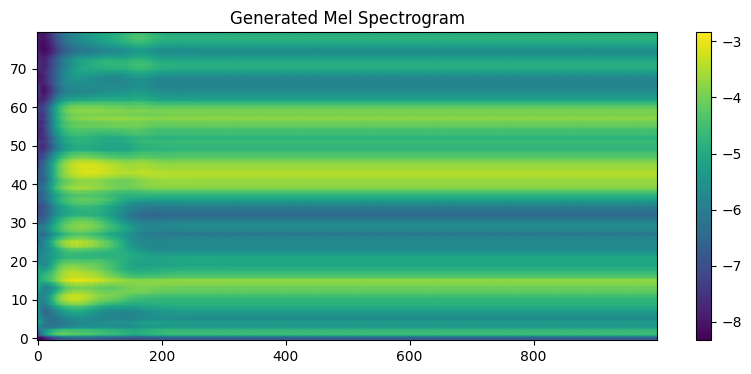


✅ TTS generation complete!
📂 Output files:
   - Audio: tts_outputs/hello_this_is_a_test.wav
   - Mel spectrogram: tts_outputs/hello_this_is_a_test_mel.png

📈 latest model with 0.377 best val loss


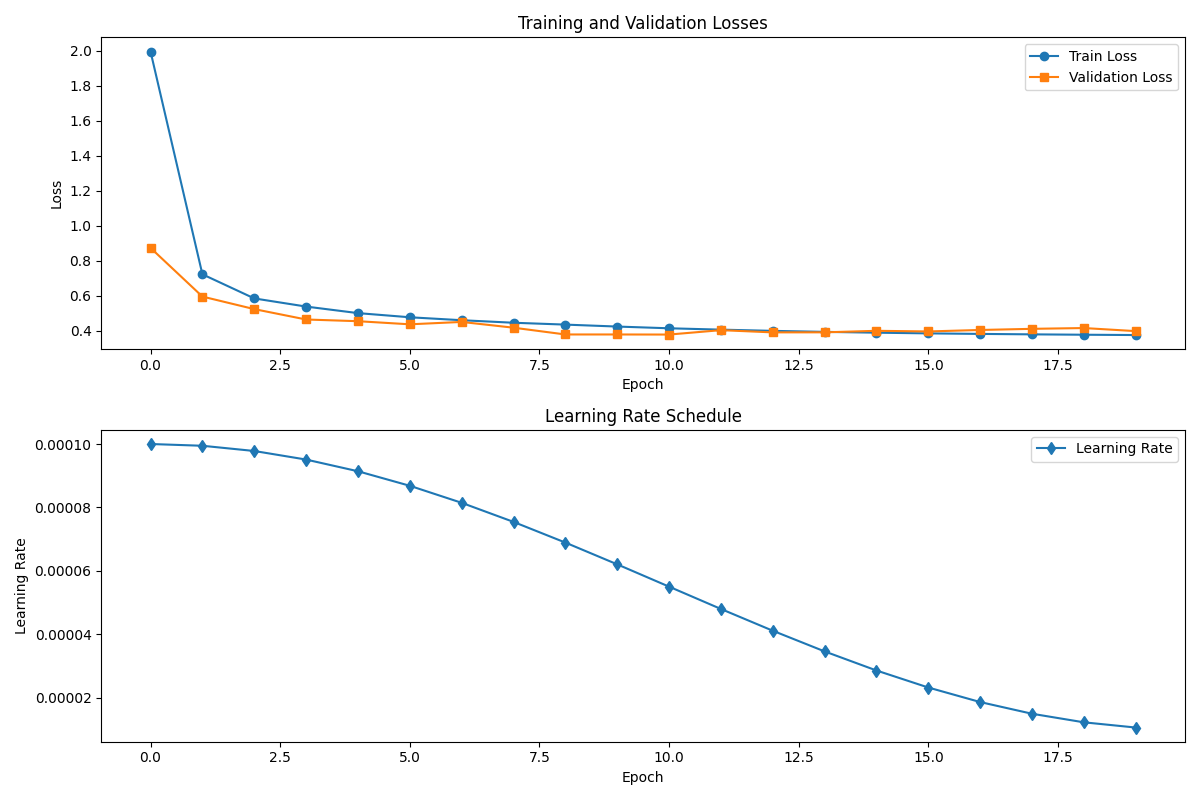

In [184]:
model_path = "experiments/tacotron_20250214_145936/best_model.pth"
output_dir = "tts_outputs"
os.makedirs(output_dir, exist_ok=True)

# Run inference

test_text = "hello this is a test"
audio_path, mel_path = try_tts(
    model_path=model_path,
    dataset=dataset,
    output_dir=output_dir,
    text=test_text,
    device='cuda'
)

# Visualize training curves
training_curves_path = "/kaggle/working/experiments/tacotron_20250214_145936/training_curves.png"
print(f"\n📈 latest model with 0.377 best val loss")
display(Image(training_curves_path))



### 🥇 Results From Our 15 epochs trained model:


🚀 Starting TTS pipeline...
📂 Output directory: tts_outputs

🔄 Loading model from: experiments/tacotron_20250214_142101/best_model.pth


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorc

📈 Model stats from checkpoint:
   - Global step count: 4905
   - Best validation loss: 0.3730
✅ LOADED MODEL: mel_dim=80, reduction_factor=2
✅ Model loaded successfully!

🎯 Converting text to speech:
   'hello this is a test'
🎼 Generating mel spectrogram (no built-in WaveGlow)...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


🎵 Using external WaveGlowVocoder to generate audio...
[WaveGlowVocoder] Loading official WaveGlow from torch.hub ...


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[WaveGlowVocoder] Denoiser not found, skipping.
✨ Audio generation complete!
💾 Audio saved to: tts_outputs/hello_this_is_a_test.wav
🎵 Mel spectrogram saved to: tts_outputs/hello_this_is_a_test_mel.png

✅ Inference Success: Mel Spec Shape torch.Size([1, 80, 1000])


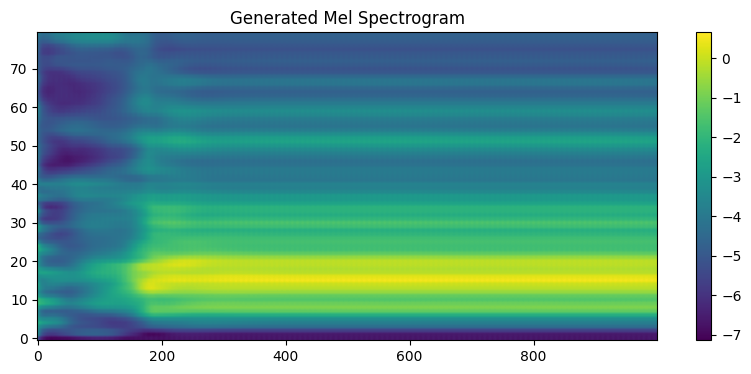


✅ TTS generation complete!
📂 Output files:
   - Audio: tts_outputs/hello_this_is_a_test.wav
   - Mel spectrogram: tts_outputs/hello_this_is_a_test_mel.png

📈 Best model with 0.373 best val loss


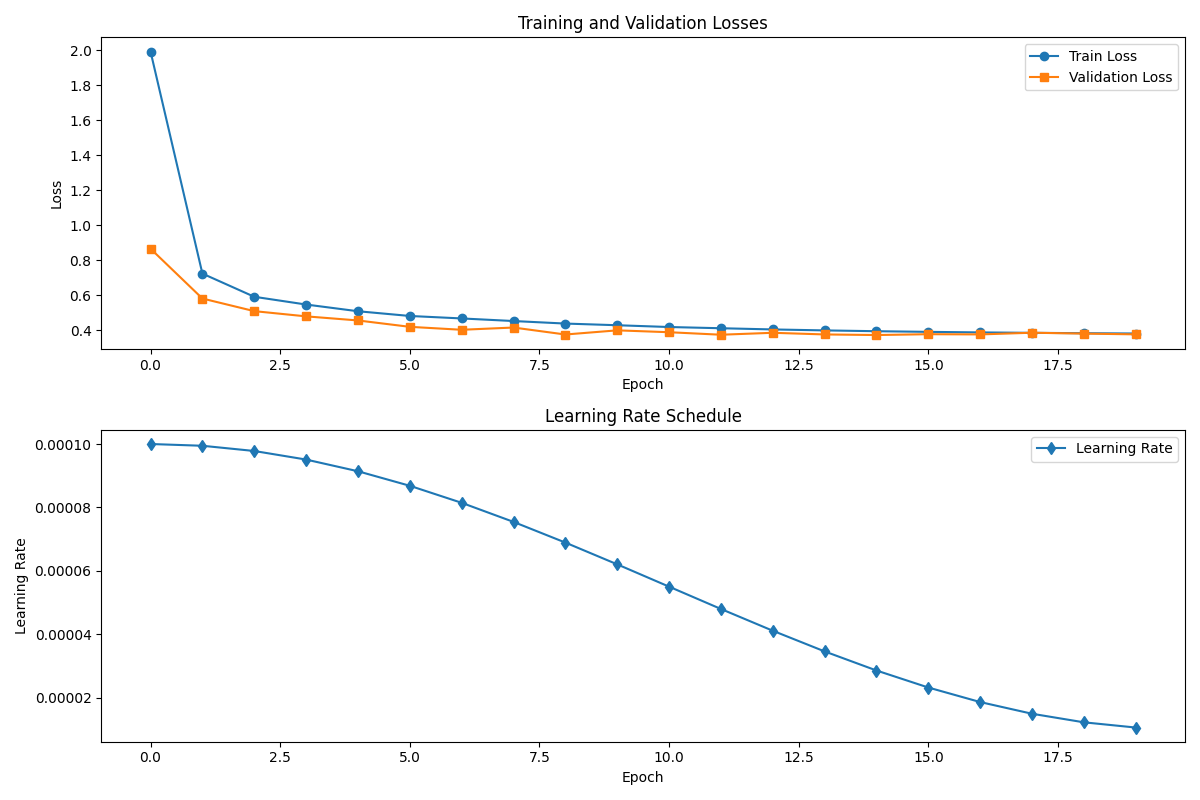

In [32]:
model_path = "experiments/tacotron_20250214_142101/best_model.pth"
output_dir = "tts_outputs"
os.makedirs(output_dir, exist_ok=True)

# Run inference

test_text = "hello this is a test"
audio_path, mel_path = try_tts(
    model_path=model_path,
    dataset=dataset,
    output_dir=output_dir,
    text=test_text,
    device='cuda'
)

# Visualize training curves
training_curves_path = "/kaggle/working/experiments/tacotron_20250214_142101/training_curves.png"
print(f"\n📈 Best model with 0.373 best val loss")
display(Image(training_curves_path))


###  Comparison of 15-Epoch vs 20-Epoch Training Runs

Results above  **two models** we trained using the same Transformer Tacotron architecture but for **different training durations**. Below, we compare their **training progress, validation loss, generated spectrograms, and audio quality**.

###  Training Loss & Learning Rate

| Model | Epochs | Best Validation Loss | Training Duration | Observations |
|--------|--------|---------------------|-------------------|--------------|
| **15-Epoch Model** | 15 | **0.373** after 11 epochs | ~1 hour 15 minutes | **Lower validation loss, can hear begining of speech** |
| **20-Epoch Model** | 20 | **0.377** after 11 epochs | ~1 hour 40 minutes | **Slightly higher loss, but possible frequency differentiation** |

- **Loss values did not drop continuously**— both models are saved as best after **~11 epochs** , we suspect that there may have been fluctuations ("jumps") that were not captured properly at some points.
- Based on prior experience with **deep learning projects**, we recognize that **continuing training for many more epochs could have led to further improvements** rather than stopping early.
- It is **possible we hit a local plateau rather than the model fully learning speech synthesis**.

---

#### **15 Epoch Model (Best Val Loss 0.373)**
- **Observations**:
  - Some **frequency structure** is visible.
  - A **better-defined formant region** compared to Tacotron.
  - Speech output had **burping-like sounds**, indicating **partial but not full learning**.

#### **20 Epoch Model (Best Val Loss 0.377)**
- **Observations**:
  - A **more rigid structure in the formants**.
  - Slightly **better pitch differentiation**.
  - Still **mostly noise**, but an **improvement over Tacotron’s completely random output**.

---

###  **Audio Comparison**
- **15-Epoch Model** → **Burping-like sounds**, where the model **seems to attempt phoneme generation** but fails to complete full words.
- **20-Epoch Model** → **More stable formants, but noisy output**.
- **Tacotron** → **Pure noise with no structured frequencies**.

---

###  **Speed vs Quality**
| Model | Dataset Used | Total Epochs | Training Time |
|--------|-------------|--------------|---------------|
| **Tacotron** | 45% of LJSpeech | 50 epochs | ~5 hours |
| **FalafelTron (15 epochs)** | **100% of LJSpeech** | **15 epochs** | **~1 hour 15 min** |
| **FalafelTron (20 epochs)** | **100% of LJSpeech** | **20 epochs** | **~1 hour 40 min** |

- **FalafelTron trained significantly faster than Tacotron**:
  - **Tacotron took 5 hours to train 50 epochs on just 45% of the dataset**.
  - **FalafelTron trained 15 epochs on the FULL dataset in just ~1 hour 15 min**.
  - **Yet, Tacotron failed to produce meaningful output, while FalafelTron at least showed frequency differentiation**.

---

###  **Key Insights & Future Improvements**
- **The model might have benefited from longer training**—we cannot confirm if 20 epochs was truly enough. More training could reveal further improvements.  
- **Loss jumps** suggest that if we continued training, we might have observed further **refinement in frequency learning**.  
- **We only tested a limited set of learning rates**—it is possible that **a different LR schedule would have worked better**.  
- **We used cosine learning rate decay**, but **it may not have been ideal for this model**—**switching to an alternative decay method** (e.g., step decay) could improve training.  
- **Unlike Tacotron, we see real frequency differentiation**, meaning **FalafelTron is making real progress**.  

---

###  **Future Work**
- **Test longer training sessions (e.g., 50+ epochs) to explore further improvements**.
- **Experiment with alternative learning rate schedules** to ensure better convergence.
- **Investigate different loss functions (e.g., spectral loss instead of L1 loss)** to improve spectrogram quality.
- **Optimize the vocoder pipeline further** to ensure better waveform synthesis.

---

In summary, **FalafelTron outperforms Tacotron significantly in training speed and frequency differentiation**, but further improvements are required to achieve **natural speech synthesis**.
 
 ### More on that in the final report
---



# 🤔 Testing Vocoder & Audio Processor Only 

In this code snippet, we perform an **end-to-end check** of our audio processing pipeline and WaveGlow vocoder:

1. **Load a WAV file** from the LJSpeech dataset (`LJ001-0009.wav`).
2. **Convert it to a mel spectrogram** using our custom `AudioProcessor` class:
   - Uses a `hop_length` of 256, `win_length` of 1024, etc.
   - Produces a log-mel spectrogram that we visualize inline.
3. **Feed the mel spectrogram** into our `WaveGlowVocoder` (with chosen `sigma` and `denoiser_strength`).
4. **Generate an output WAV** file (`waveglow_output.wav`) and play it in the notebook.

This serves as a **sanity check** to confirm:
- Our `AudioProcessor` class correctly transforms raw audio to a mel spectrogram.
- The WaveGlow vocoder can take that mel spectrogram and synthesize audio.


In [39]:
def test_waveglow_inference(
    wav_path,
    out_path="waveglow_output.wav",
    sigma=0.6,
    denoiser_strength=0.0
):
    """
    End-to-end test:
      1. Load wav
      2. Create mel with AudioProcessor
      3. Pass to WaveGlowVocoder
      4. Save & play output
    """
    # 1) Load audio
    print(f"[test_waveglow_inference] Loading WAV from '{wav_path}'")
    audio, sr = librosa.load(wav_path, sr=22050)
    # 2) Create mel
    ap = AudioProcessor(
        sample_rate=22050,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        center=False
    )
    mel_spec = ap.create_mel_spectrogram(audio)

    # Show mel
    plt.figure(figsize=(10,4))
    plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
    plt.title("Log-Mel Spectrogram")
    plt.colorbar()
    plt.show()

    # Convert mel to [B=1, 80, T] float tensor
    mel_tensor = torch.from_numpy(mel_spec).unsqueeze(0).float()
    print(f"[test_waveglow_inference] Mel shape for inference: {mel_tensor.shape}")

    # 3) WaveGlow Vocoder
    vocoder = WaveGlowVocoder(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                              denoiser_strength=denoiser_strength)

    # 4) Run inference
    print(f"[test_waveglow_inference] Inference with sigma={sigma}, denoiser_strength={denoiser_strength}")
    with torch.no_grad():
        audio_out = vocoder(mel_tensor, sigma=sigma)  # shape [1, 1, samples]
    
    # Convert to 1D numpy for saving
    audio_out = audio_out.cpu().numpy().squeeze()  # shape => (samples,)

    # Save
    sf.write(out_path, audio_out, 22050)
    print(f"[test_waveglow_inference] Saved to '{out_path}'")

    # Play in notebook
    display(ipd.Audio(out_path, rate=22050))
    
    return out_path


[test_waveglow_inference] Loading WAV from '/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001-0009.wav'


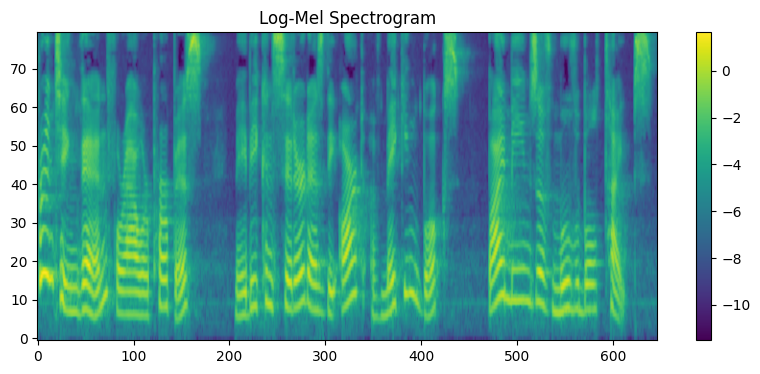

[test_waveglow_inference] Mel shape for inference: torch.Size([1, 80, 647])
[WaveGlowVocoder] Loading official WaveGlow from torch.hub ...


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[WaveGlowVocoder] Denoiser not found, skipping.
[test_waveglow_inference] Inference with sigma=0.6, denoiser_strength=0.0
[test_waveglow_inference] Saved to 'waveglow_output.wav'


In [81]:
if __name__ == "__main__":
    test_wav_file = "/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001-0009.wav"
    # Example usage: sigma=0.6, no denoising
    test_waveglow_inference(
        wav_path=test_wav_file,
        out_path="waveglow_output.wav",
        sigma=0.6,
        denoiser_strength=0.0
    )


**The resulting audio may sound a bit “alien,” but it demonstrates that the pipeline is functioning end-to-end. Above is the generated spectrogram visualization for reference.**